# Chapter 3

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from joblib import load, dump


In [6]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [11]:
type(mnist['data'])

numpy.ndarray

In [12]:
type(mnist)

sklearn.utils.Bunch

In [7]:
X, y = mnist['data'], mnist['target']

In [21]:
#np.save("datasets/chapter3/X", X)
#np.save("datasets/chapter3/y",y)

In [15]:
# X = np.load("datasets/chapter3/X.npy")
# y = np.load("datasets/chapter3/y.npy", allow_pickle=True)

In [12]:
X.shape

(70000, 784)

In [13]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset.

In [16]:
some_digit = X[0]

In [17]:
some_digit_image = some_digit.reshape(28, 28)

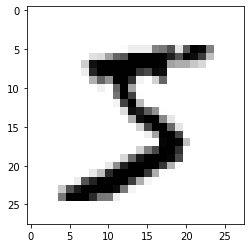

In [18]:
plt.imshow(some_digit_image, cmap='binary')

In [22]:
y[0]

5

In [20]:
type(y)

numpy.ndarray

In [21]:
y = y.astype(np.uint8)

> ---
>
> #### Note:
>
> This dataset is already split in the training and test sets.  Data is already shuffled as well
>
> ---

In [23]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training Binary Classifier

In [31]:
y_train_5 = (y_train == 5)

In [32]:
y_test_5 = (y_test == 5)

In [33]:
y_train_5

array([ True, False, False, ...,  True, False, False])

### SGDClassifier (Stochastic Gradient Descent)

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [35]:
from sklearn.linear_model import SGDClassifier

In [39]:
sgd_clf = SGDClassifier(random_state=42)

In [40]:
sgd_clf.fit(X_train, y_train_5)

NameError: name 'y_train_5' is not defined

In [37]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measure

Evaluating a classifier is often significantly trickier than evaluating a regressor

### Cross Validation Implementation

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def my_cross_validation():
  skfolds = StratifiedKFold(n_splits=3, random_state=42)
  for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

### Scoring with cross_val_score

In [31]:
from sklearn.model_selection import cross_val_score

In [40]:
score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [41]:
score

array([0.95035, 0.96035, 0.9604 ])

---
> #### NOTE

The score is pretty high but that's not a good indicator.  A classifier that always returns false in this case would be equally effective.  If the number are distributed equally, there is about 90% chance 5 is not the number under test. Accuracy is generally NOT a preferred performance measure for qualifiers.

---

### Confusion Matrix

---
> #### DEFINITION
>The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

---

In [33]:
from sklearn.model_selection import cross_val_predict

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [44]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [59]:
from sklearn.metrics import confusion_matrix

In [46]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,825 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

<img src="images/chapter_3/precision.png" width="25%"/>

<img src="images/chapter_3/recall.png" width="25%" />

<img src="images/chapter_3/diagram.png" width=600px/>

In [47]:
from sklearn.metrics import precision_score, recall_score

In [48]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [49]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### F1 Score
It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high. The F1 score favors classifiers that have similar precision and recall.  Sometimes that might not be what we want.

<img src="images/chapter_3/f1.png" width="50%" />

In [37]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_train_5, y_train_pred)

---
> #### DEFINITION
> **Precision / Recall Tradeoff:**
> Increasing precision reduces recall, and vice versa.


> <img src="images/chapter_3/precision-recall-tradeoff.png" width="50%"/>

---

In [51]:
y_scores = sgd_clf.decision_function([some_digit])

In [52]:
y_scores

array([2164.22030239])

In [53]:
threshold = 0

In [54]:
y_some_digit_pred = (y_scores > threshold)

In [55]:
y_some_digit_pred

array([ True])

In [56]:
threshold = 8000

In [57]:
y_some_digit_pred = (y_scores > threshold)

In [58]:
y_some_digit_pred

array([False])

## Curves

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [60]:
from sklearn.metrics import precision_recall_curve

### Precision Recall Curve

In [224]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [228]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


In [226]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

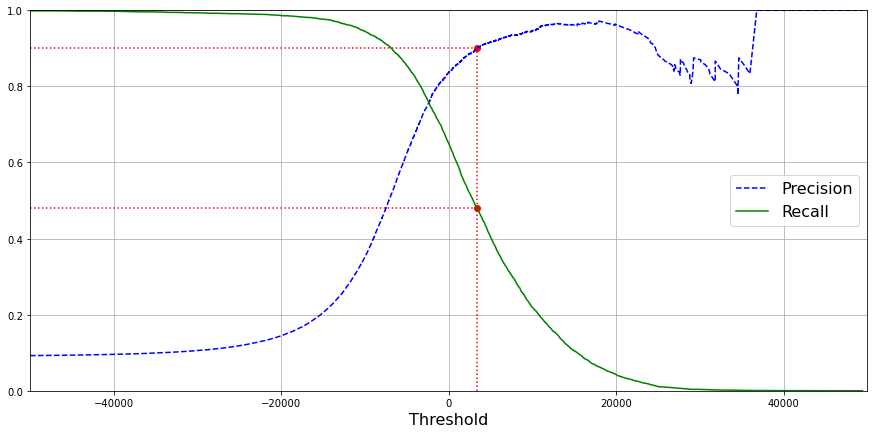

In [227]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(15,7))
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

plot_precision_recall_vs_threshold(precisions,recalls, thresholds)


In [65]:
plt.plot(recalls[:-1], precisions[:-1])

In [70]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [71]:
threshold_90_precision # this will be the threshold needed for 90 % precision

3370.0194991439557

Precision of 90 

In [75]:
y_train_pred_90 = (y_scores >= threshold_90_precision) 

In [76]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [77]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [79]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [78]:
confusion_matrix(y_train_5, y_train_pred_90)

array([[54290,   289],
       [ 2819,  2602]])

### ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [81]:
from sklearn.metrics import roc_curve

In [86]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [153]:
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel("False Positive Rate", fontsize=16)        # Not shown
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)        # Not shown
    plt.plot([0,1], [0,1], 'o--')
    plt.grid(True)                              # Not shown


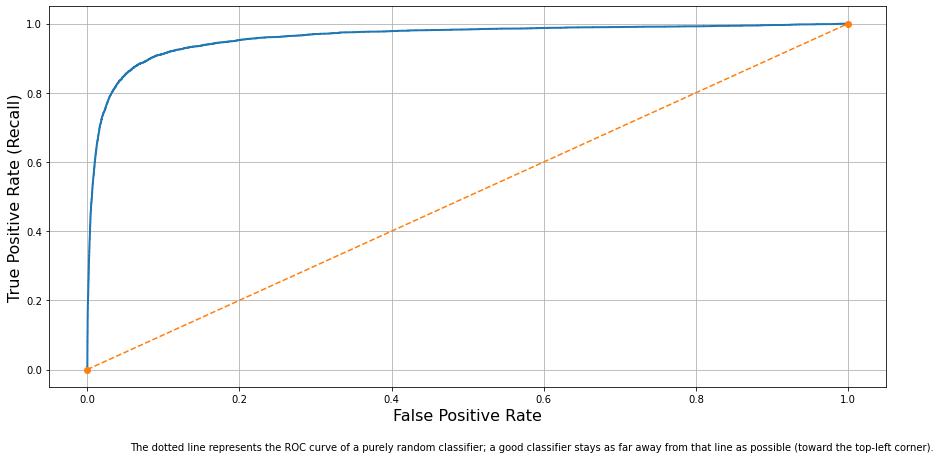

In [154]:
plt.figure(figsize=(15,7))
plt.figtext(0.2, 0.0, "The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).")
plot_roc_curve(fpr, tpr, thresholds)

One way to estimate the accuracy of the classifier is to look at AUC (Area Under Curve).  
 * The perfect classifier will have AUC of 1
 * Purely random classifier will have AUC of 0.5

In [130]:
from sklearn.metrics import roc_auc_score

In [131]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

---
> #### TIP
> Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).
---

## Random Forest Classifier
The `RandomForestClassifier` does not have a `decision_function` method. Instead, it has a `predict_proba()`
method. Scikit-Learn classifiers generally have one or the other, or both.
The method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
forest_clf = RandomForestClassifier(random_state=42)

In [134]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [135]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [141]:
y_scores_forest = y_probas_forest[:, 1]

In [139]:
y_scores_forest

array([0.11, 0.99, 0.96, ..., 0.02, 0.92, 0.94])

In [169]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [170]:
forest_plot_text = "Comparing ROC curves: the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC"

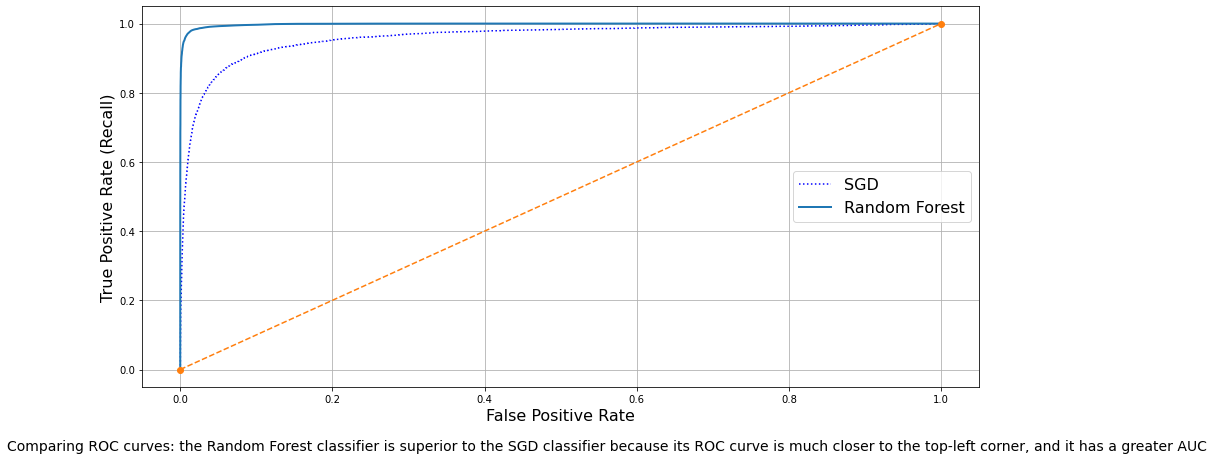

In [171]:
plt.figure(figsize=(15,7))
plt.figtext(0.0, 0.0, forest_plot_text, fontsize=14)
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="center right", fontsize=16)


In [173]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [177]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

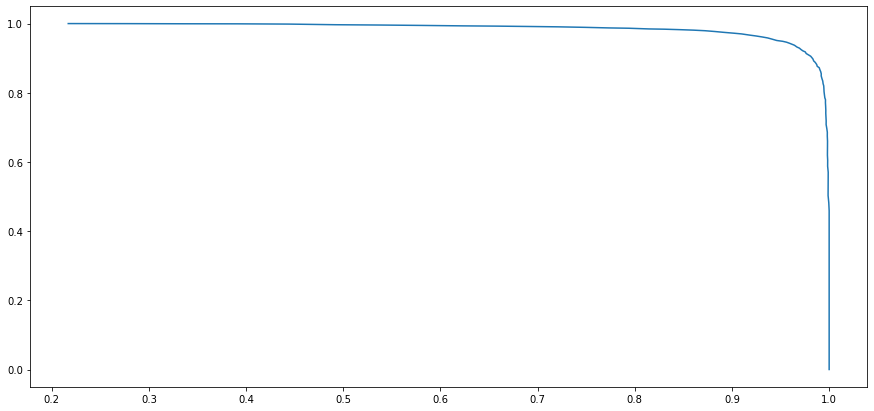

In [182]:
plt.figure(figsize=(15,7))
plt.plot(precisions_forest, recalls_forest)

In [235]:
plt.figure(figsize=(15,7))
plt.plot(thresholds_forest, precisions_forest[:-1])
plt.plot(thresholds_forest, recalls_forest[:-1])

In [199]:
precisions_forest_90 = thresholds_forest[np.argmax(precisions_forest >= 0.99)]

In [200]:
precisions_forest_90

0.51

In [201]:
y_train_pred_90_forset = (y_scores_forest >= precisions_forest_90) 

In [202]:
y_train_pred_90_forset

array([ True, False, False, ...,  True, False, False])

In [203]:
precision_score(y_train_5, y_train_pred_90_forset)

0.9905083315756169

In [204]:
recall_score(y_train_5, y_train_pred_90_forset)

0.8662608374838591

## Multiclass Classification

Some ML classifiers have ability to classify multiple classes: 
 * SGD Classifier
 * Random Forest Classifier
 * Naive Bayes
 
We can also work with strictly binary classifiers (Logistic Regression, Support Vector Machines) to classify multiple classes: 
 * OvR - One Versus the Rest - For this example we would an is-numer? classfier for each number.  The prediction would then be result of classification with highest score. for given digit.
 * OvO - One Versus One - We would train a set of classifiers that would classify between 2 digits. So we would have 0vs1 classifier 0vs2 classifier 1vs2 classifier and so on.  We would then choose the prediction that wins the most "duels"
 * OvO Trains a bigger number of classifiers N * (N -1) / 2 for N classes, but each classifier is trained against limited number of examples.  For example 0vs2 would be trained only against examples with result 0 or 2.  This is good approach for algorithms that don't scale well with large number of examples in training set. 

> ---
> #### NOTE
> Scikit-Learn automatically detects when using binary classification algorithms try to classify multiple classes and uses OvR or OvO based on algorithm used.
>
> ---

In [1]:
from sklearn.svm import SVC

In [2]:
svm_clf = SVC()

In [9]:
svm_clf.fit(X_train, y_train)

SVC()

In [11]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [12]:
some_digit_scores = svm_clf.decision_function([some_digit]) 

In [13]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [14]:
np.argmax(some_digit_scores)

5

In [16]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [17]:
svm_clf.classes_[np.argmax(some_digit_scores)]

'5'

### Forcing OvO or OvR 

We can force the classifier to use OvO or OvR strategy.

In [18]:
from sklearn.multiclass import OneVsRestClassifier

In [19]:
ovr_clf = OneVsRestClassifier(SVC())

In [21]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [22]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [23]:
len(ovr_clf.estimators_)

10

In [34]:
# dump(ovr_clf, 'cache/chapter3/ovr_clf')

### Full Data with SGDClassifier

In [42]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [51]:
#dump(sgd_clf, 'cache/chapter3/sgd_clf_all_classes')

In [49]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Interesting thing happened here.  In the book example, the result was accurate, but it was mentioned that 3 was a close second.  In this experiment, 3 was actually a better fit according to this classifier.

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy') 

array([0.87365, 0.85835, 0.8689 ])

Accuracy is still decent. Seems like the previous example was one of the few bad decisions for this classifier.

> ---
> #### NOTE:
> Scaling input should help.  Why is the input not scaled before fitting (in the book)?
> 
> ---

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [55]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=5, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

A small improvement

## Error Analysis

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=5)

In [67]:
dump(y_train_pred, 'cache/chapter3/y_train_pred')

['cache/chapter3/y_train_pred']

In [69]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [66]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(conf_mx, cmap=plt.cm.gray)

Diagonal idicates correct guesses.  We can observe that 5 is slightly darker, indicating that there were either less cases of 5 in dataset or there is an issue with classifying 5s (it does not perform as well as other digits). To analyze the errors better we need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [77]:
'''Sums all columns in single row'''
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [83]:
''' Error rates for each matrix entry'''
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.        , 0.00371433, 0.00084417, 0.00135067,
        0.00725983, 0.006078  , 0.001013  , 0.03798751, 0.00016883],
       [0.        , 0.        , 0.00548799, 0.00355977, 0.0005933 ,
        0.00652625, 0.0005933 , 0.00103827, 0.03144468, 0.00148324],
       [0.00453172, 0.00453172, 0.        , 0.01544142, 0.01225243,
        0.00453172, 0.01124538, 0.0060423 , 0.06344411, 0.00184626],
       [0.00358832, 0.00277279, 0.01908335, 0.        , 0.00032621,
        0.03311042, 0.00440385, 0.00652422, 0.06573153, 0.0119067 ],
       [0.00205409, 0.00239644, 0.00701814, 0.00154057, 0.        ,
        0.00205409, 0.00581992, 0.0046217 , 0.05939747, 0.02807258],
       [0.00498063, 0.00276702, 0.00553403, 0.03099059, 0.00977679,
        0.        , 0.01383509, 0.00258255, 0.09869028, 0.01106807],
       [0.00506928, 0.00253464, 0.00709699, 0.00050693, 0.00743494,
        0.01639067, 0.        , 0.00050693, 0.02213586, 0.00016898],
       [0.00335196, 0.00159617, 0.0081404

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(norm_conf_mx, cmap=plt.cm.gray)

We can tell from this matrix that classifier misclassifies a lot of numbers as 8, though it does recognize 8 correctly for the most part.  We can also tell that 5 and 3 and misclassified as each other quite a lot (both ways).  It seems like the focus to improve this situation, would be to either add some examples with a shape of 8 that gets misclassified.  We could also add some additional features to help classifier recognize numbers properly (image processing libraries).  We could for example add number of loops as a feature where 8 would have 2, 6 would have 1 and 5 would have none.

## Multilabel Classification

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
y_train_large = (y_train >= 7)

In [25]:
y_train_odd = (y_train % 2 == 1) 

In [26]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [27]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [30]:
knn_clf = KNeighborsClassifier()

In [31]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [32]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [36]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [40]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multioutput Classification 
Simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [43]:
noise = np.random.randint(0,100, (len(X_train), 784))

In [44]:
noise

array([[99, 77, 18, ..., 72, 26, 28],
       [71, 17,  7, ..., 56, 28, 25],
       [41, 98, 76, ..., 18, 48, 91],
       ...,
       [43, 44, 51, ..., 12, 38, 15],
       [81, 95, 93, ..., 14, 46, 98],
       [64, 99, 21, ..., 89,  7, 83]])

In [45]:
X_train_mod = X_train + noise

In [46]:
noise = np.random.randint(0,100, (len(X_test), 784))

In [47]:
X_test_mod = X_test + noise

In [48]:
y_train_mod = X_train

In [49]:
y_test_mod = X_test

In [80]:
def plot_digit(digit):
    some_digit_image = digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap='binary')

In [55]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [77]:
some_index = 6
clean_digit = knn_clf.predict([X_test_mod[some_index]])
dirty_digit = X_test_mod[some_index]

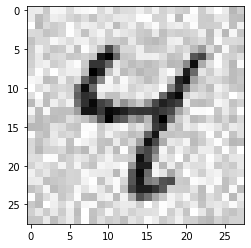

In [78]:
plot_digit(dirty_digit)

In [79]:
plot_digit(clean_digit)